In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [0]:
from sklearn.cluster import KMeans

In [0]:
import numpy as np
import cStringIO # *much* faster than StringIO
import urllib
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import random
from sklearn.cluster import KMeans
from skimage.segmentation import mark_boundaries


In [0]:
def url_to_image(url):
    file = urllib.urlopen(url)
    # constructs a StringIO holding the image
    img_data = cStringIO.StringIO(file.read())
    img = Image.open(img_data)
    return img


def image_to_rgbarray(image):
    return np.array(image)


In [0]:
def black_and_white_mode():
    colors = [(0, 0, 0), (255, 255, 255)]
    return colors


def color_mode(bit, shape):
    color_min = 0
    color_max = 255
    colors = []
    for i in range(0, shape[0]):
        colors.append((random.randint(color_min, color_max), random.randint(
            color_min, color_max), random.randint(color_min, color_max)))
    return colors


In [0]:
def sort_centers(centers):
    n = len(centers)
    for i in range(n):
        # Last i elements are already in place
        for j in range(0, n-i-1):
            # traverse the centersay from 0 to n-i-1
            # Swap if the element found is greater than the next element
            if centers[j][0] > centers[j+1][0]:
                centers[j], centers[j+1] = centers[j+1], centers[j]
            elif centers[j][0] == centers[j+1][0]:
                if centers[j][1] > centers[j+1][1]:
                    centers[j], centers[j+1] = centers[j+1], centers[j]
                elif centers[j][1] == centers[j+1][1]:
                    if centers[j][2] > centers[j+1][2]:
                        centers[j], centers[j+1] = centers[j+1], centers[j]
    return centers


In [0]:
def segmented_image_portions_bw(original_image, centers, labels, inverted=False):
    image = original_image
    original_shape = image.shape
    image = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))

    if(inverted):
        seg = (0, 0, 0)
        rest = (255, 255, 255)
    else:
        seg = (255, 255, 255)
        rest = (0, 0, 0)

    for i in range(0, image.shape[0]):
        image[i, :] = rest

    centers_count = centers.shape[0]

    seg_portions = [image for i in range(0, centers_count)]
    seg_portions = np.array(seg_portions)

    for i in range(0, image.shape[0]):
        cluster_no = labels[i]
        seg_portions[cluster_no][i, :] = seg

    return seg_portions


def segmented_image_portions(original_image, centers, labels):
    image = original_image
    original_shape = image.shape
    image = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))

    for i in range(0, image.shape[0]):
        image[i, :] = (0, 0, 0)

    centers_count = centers.shape[0]

    seg_portions = [image for i in range(0, centers_count)]
    seg_portions = np.array(seg_portions)
   
    for i in range(0, image.shape[0]):
        cluster_no = labels[i]
        seg_portions[cluster_no][i, :] = centers[cluster_no]
   
    return seg_portions

def mark_bounds(seg_image,labels,color=(1, 1, 0), mode='outer'):
    labels = labels.reshape((seg_image.shape[0],seg_image.shape[1]))
    seg_image = mark_boundaries(seg_image, labels,color=color, mode=mode)
    return seg_image


In [0]:
def kmeans_seg(image_url, cluster_count, init_centers):

    # Extract pixel data from image
    original_image = url_to_image(image_url)
    original_image_data = image_to_rgbarray(original_image)
    image = image_to_rgbarray(original_image)

    # Plot original Image
    plt.figure()
    plt.axis("off")
    plt.title("Original Image")
    plt.imshow(image)

    print("original shape: " + str(image.shape))

    # Reshape image
    original_shape = image.shape
    image = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))

    print("converted shape: " + str(image.shape))

    # cluster_count = 2 for B&W mode
    # cluster_count > 2 for color mode

    if init_centers is None:
        kmeans = KMeans(n_clusters=cluster_count)
    else:
        kmeans = KMeans(n_clusters=cluster_count, init=init_centers)

    # main kmeans algo
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(image)
    labels = kmeans.predict(image)

    kmeans_centers = kmeans.cluster_centers_

    print("centers: " + str(kmeans_centers))

    # colors = color_mode(cluster_count,centers.shape)
    # colors = black_and_white_mode()

    colors = kmeans_centers

    # assign color of their respective cluster center for each pixel
    for i in range(0, image.shape[0]):
        cluster_no = labels[i]
        image[i, :] = colors[cluster_no]

    # convert back to original shape
    kmeans_seg_image = image.reshape(original_shape)

    # Plot segmented image
    plt.figure()
    plt.axis("off")
    plt.title("Quantized Image")
    # plt.gray()
    plt.imshow(kmeans_seg_image)

    segmented_portion_color_inverted = False

    # Extract segment data in color and B/W for every segment
    segmented_portions_kmeans  = segmented_image_portions(
        original_image_data, kmeans_centers, labels)

    segmented_portions_kmeans = np.reshape(
        segmented_portions_kmeans, (segmented_portions_kmeans.shape[0],) + original_shape)

    segmented_portions_bw_kmeans = segmented_image_portions_bw(
        original_image_data, kmeans_centers, labels, segmented_portion_color_inverted)

    segmented_portions_bw_kmeans = np.reshape(
        segmented_portions_bw_kmeans, (segmented_portions_bw_kmeans.shape[0],) + original_shape)

    # plot segmented portions
    for i in range(0, segmented_portions_kmeans.shape[0]):
        f = plt.figure()
        f.set_figheight(18)
        f.set_figwidth(17.6)
        f.add_subplot(1, 2, 1)
        plt.axis("off")
        plt.title("Segmented Portion: " + str(i+1))
        plt.imshow(segmented_portions_kmeans[i])
        f.add_subplot(1, 2, 2)
        plt.axis("off")
        plt.title("Segmented Portion B&W: " + str(i+1))
        if(segmented_portion_color_inverted):
            black_patch = mpatches.Patch(
                color='black', label='Segemented Portion')
            white_patch = mpatches.Patch(
                color='white', label='Rest of the Image')
            legend = plt.legend(handles=[black_patch, white_patch], loc=9,
                                shadow=False, frameon=True, bbox_to_anchor=(0.5, -0.1), ncol=2)
        else:
            white_patch = mpatches.Patch(
                color='white', label='Segemented Portion')
            black_patch = mpatches.Patch(
                color='black', label='Rest of the Image')
            legend = plt.legend(handles=[white_patch, black_patch], loc=9,
                                shadow=False, frameon=True, bbox_to_anchor=(0.5, -0.1), ncol=2)
        frame = legend.get_frame()
        frame.set_facecolor('#EEEEEE')
        frame.set_edgecolor('black')
        plt.imshow(segmented_portions_bw_kmeans[i])

    return kmeans_seg_image, colors, labels


original shape: (481, 321, 3)
converted shape: (154401, 3)
centers: [[189.4780909  171.77250715 109.57383745]
 [ 86.63870992  63.31210913  40.82181117]
 [241.98963542 232.49428124 185.00826163]
 [146.74429924 116.03797953  64.68244357]
 [ 42.08693411  37.71205223  19.16149815]]


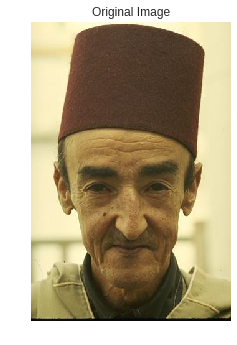

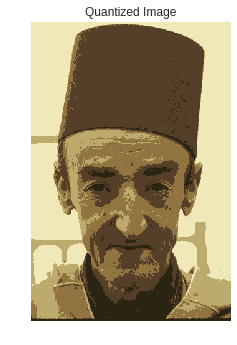

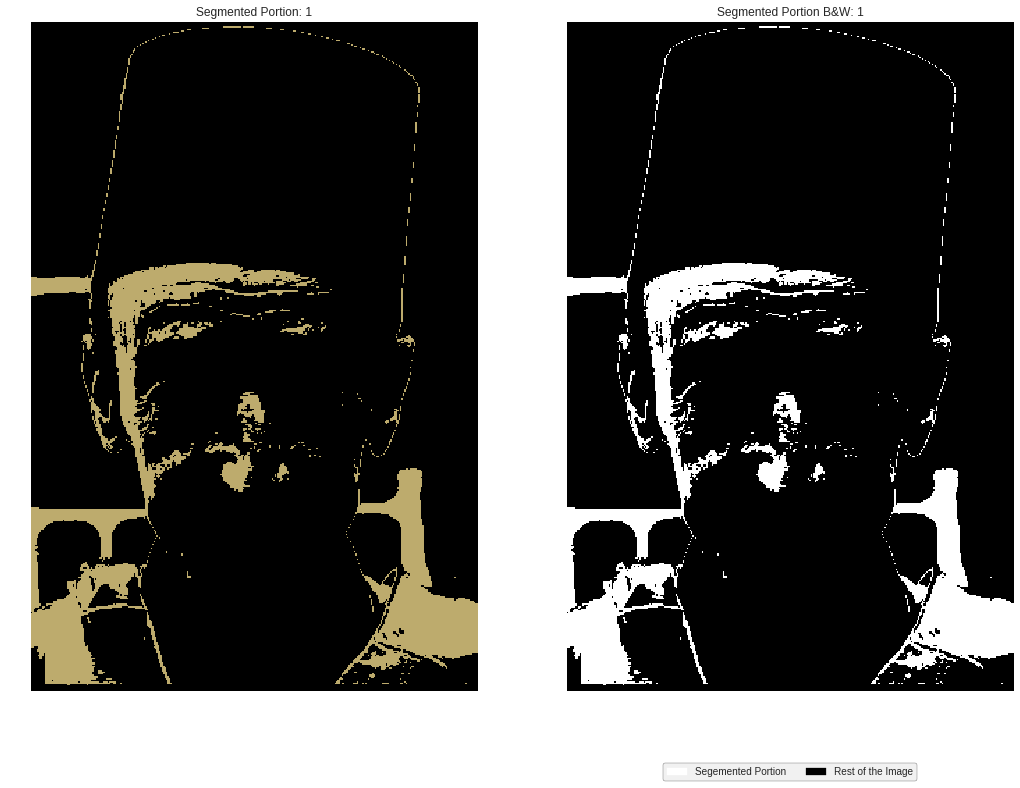

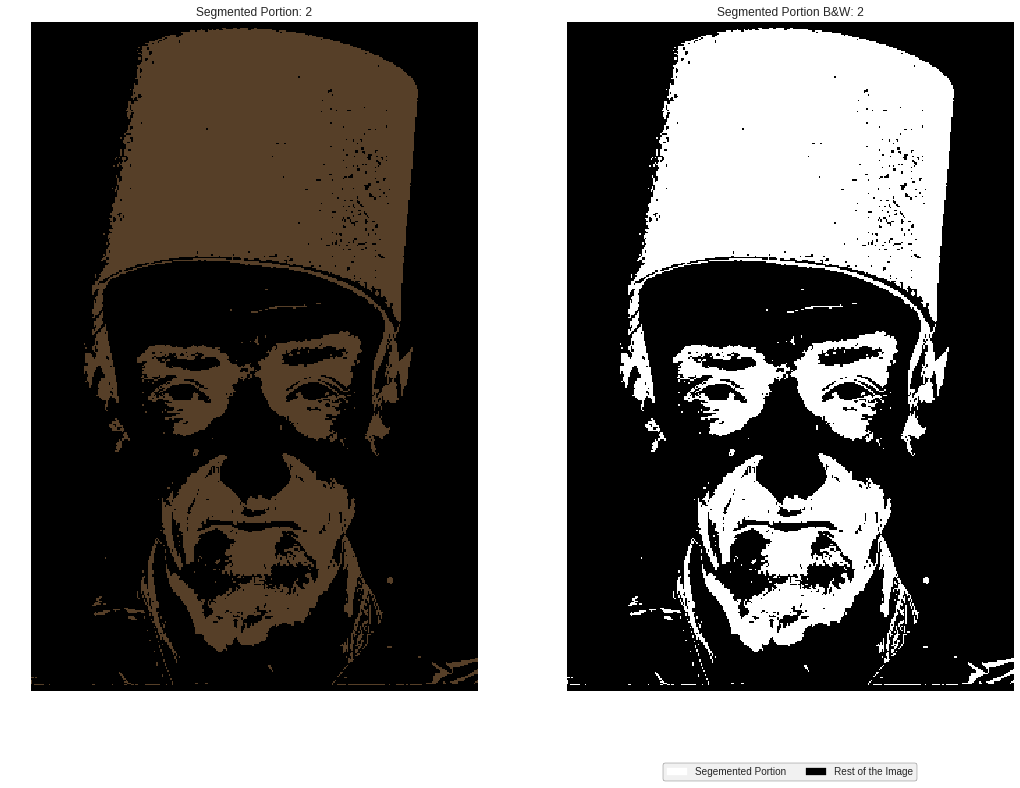

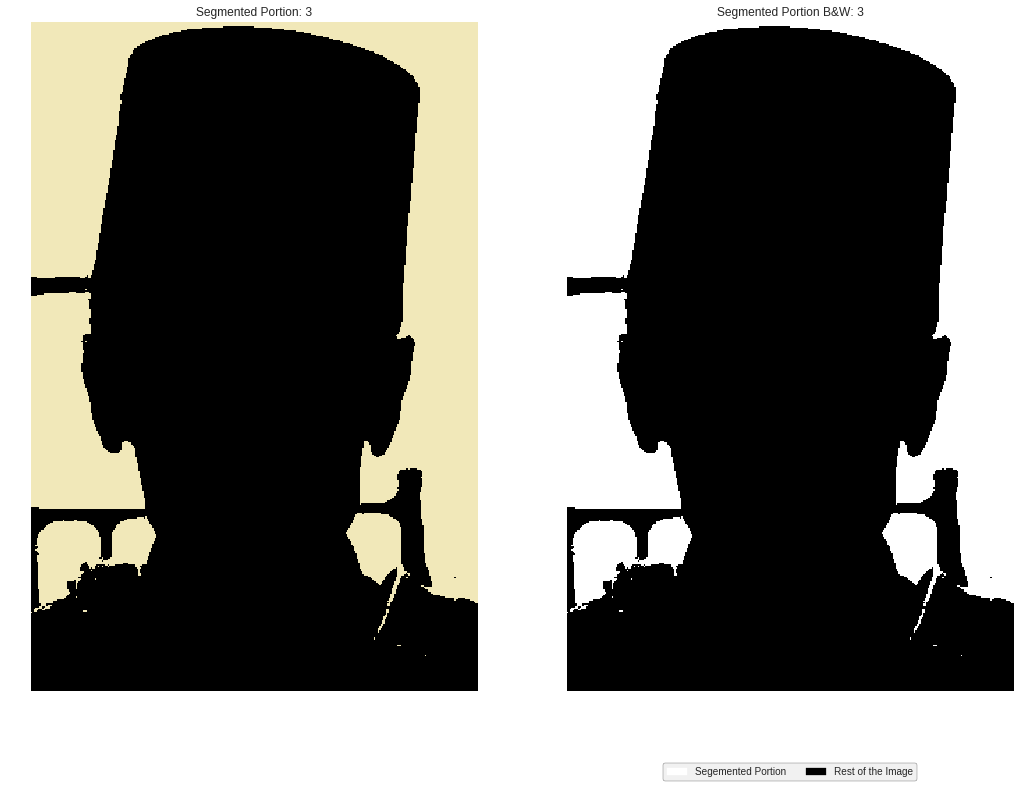

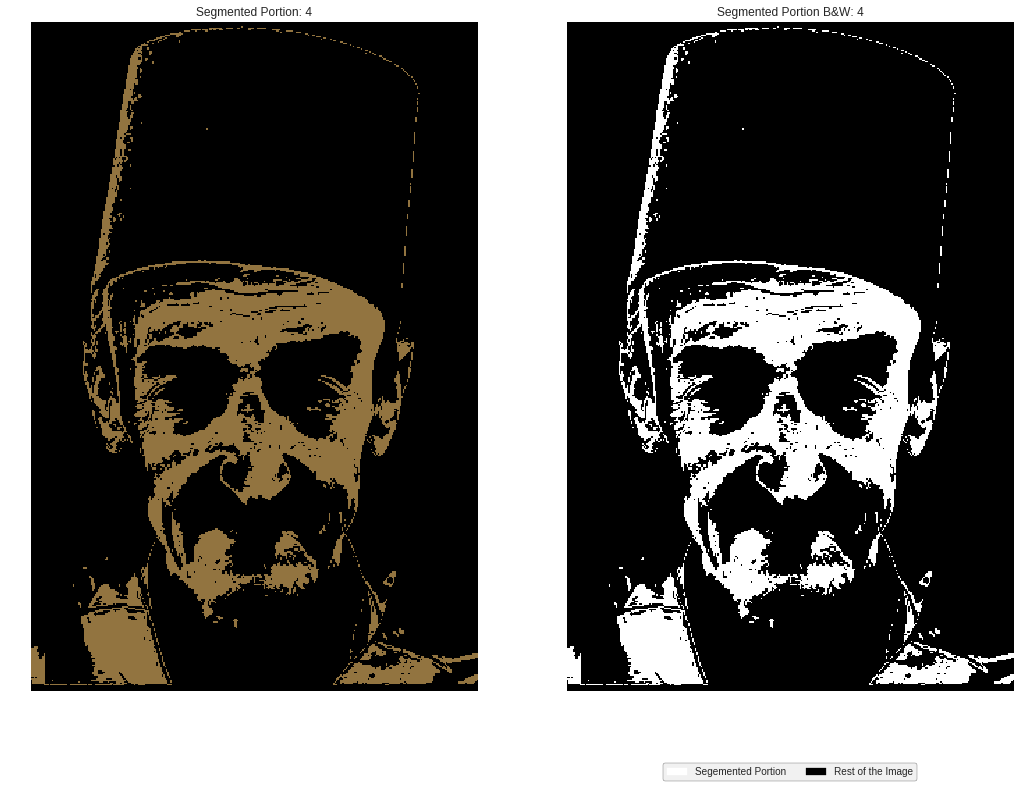

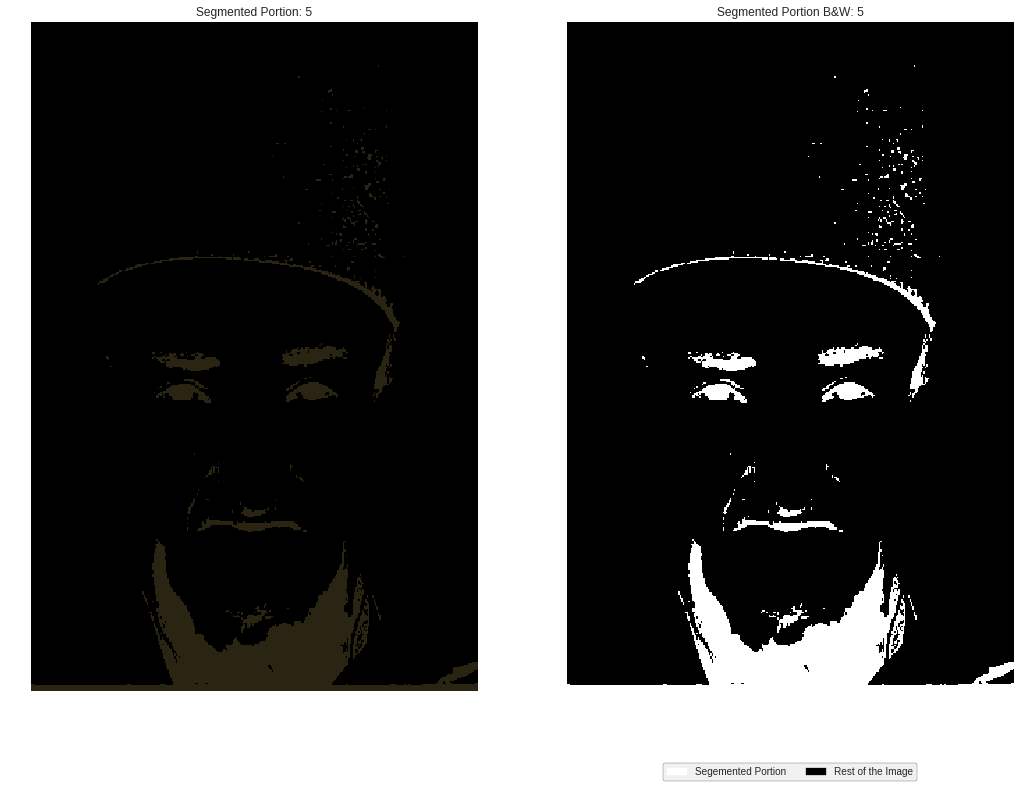

In [9]:
#@title K-Means Segmentation { display-mode: "form" }
IMAGE_URL = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/189080.jpg" #@param {type:"string"}
CLUSTER_COUNT = 5 #@param {type:"integer"}

url = IMAGE_URL
clusters = CLUSTER_COUNT
kmeans_seg_image,kmeans_centers,kmeans_labels = kmeans_seg(cluster_count=clusters,image_url=url,init_centers=None)

In [10]:
!pip install scikit-fuzzy

    100% |████████████████████████████████| 1.0MB 16.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/81/d9/eb/b8321c08339f51be3e991e7ae45b9673270cb8ca8271482ab1
Successfully built scikit-fuzzy


In [0]:
# https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.html#skfuzzy.cmeans

import skfuzzy as fuzzy

In [0]:
def get_labels(cluster_membership):
    labels = []
    for pixel in cluster_membership.T:
        labels.append(np.argmax(pixel))
    return labels


In [0]:
def fcm_seg(image_url, cluster_count, fuzziness=1.7):

    original_image = url_to_image(image_url)
    original_image_data = image_to_rgbarray(original_image)
    image = image_to_rgbarray(original_image)

    # Plot original Image
    plt.figure()
    plt.axis("off")
    plt.title("Original Image")
    plt.imshow(image)

    print("original shape: " + str(image.shape))

    original_shape = image.shape
    image = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))

    print("converted shape: " + str(image.shape))

    #  m is the hyper- parameter that controls how fuzzy the cluster will be. The higher it is, the fuzzier the cluster will be in the end.
    # decided as 1.7 by reading this paper: https://link.springer.com/chapter/10.1007%2F978-3-642-21697-8_41
    m_hyp = fuzziness

    # other parameters for fcm
    accepatble_error = 0.0001
    max_iterations = 1000

    cntr, u, u0, d, jm, p, fpc = fuzzy.cmeans(
        data=image.T, c=cluster_count, m=m_hyp, error=accepatble_error, maxiter=max_iterations, init=None, seed=None)

    fcm_centers = cntr  # centers
    labels = u  # membership values of a pixel for each cluster

    print("centers: " + str(fcm_centers))
    print("jm: "+str(jm[-1]))

    colors = fcm_centers

    labels = get_labels(labels)

    for i in range(0, image.shape[0]):
        cluster_no = labels[i]
        image[i, :] = colors[cluster_no]

    fuzzy_seg_image = image.reshape(original_shape)

    plt.figure()
    plt.axis("off")
    plt.title("Quantized Image")
    plt.imshow(fuzzy_seg_image)

    segmented_portion_color_inverted = False

    segmented_portions_fcm = segmented_image_portions(
        original_image_data, colors, labels)

    segmented_portions_fcm = np.reshape(
        segmented_portions_fcm, (segmented_portions_fcm.shape[0],) + original_shape)

    segmented_portions_bw_fcm = segmented_image_portions_bw(
        original_image_data, colors, labels, segmented_portion_color_inverted)

    segmented_portions_bw_fcm = np.reshape(
        segmented_portions_bw_fcm, (segmented_portions_bw_fcm.shape[0],) + original_shape)

    for i in range(0, segmented_portions_fcm.shape[0]):
        f = plt.figure()
        f.set_figheight(18)
        f.set_figwidth(17.6)
        f.add_subplot(1, 2, 1)
        plt.axis("off")
        plt.title("Segmented Portion: " + str(i+1))
        plt.imshow(segmented_portions_fcm[i])
        f.add_subplot(1, 2, 2)
        plt.axis("off")
        plt.title("Segmented Portion B&W: " + str(i+1))
        if(segmented_portion_color_inverted):
            black_patch = mpatches.Patch(
                color='black', label='Segemented Portion')
            white_patch = mpatches.Patch(
                color='white', label='Rest of the Image')
            legend = plt.legend(handles=[black_patch, white_patch], loc=9,
                                shadow=False, frameon=True, bbox_to_anchor=(0.5, -0.1), ncol=2)
        else:
            white_patch = mpatches.Patch(
                color='white', label='Segemented Portion')
            black_patch = mpatches.Patch(
                color='black', label='Rest of the Image')
            legend = plt.legend(handles=[white_patch, black_patch], loc=9,
                                shadow=False, frameon=True, bbox_to_anchor=(0.5, -0.1), ncol=2)
        frame = legend.get_frame()
        frame.set_facecolor('#EEEEEE')
        frame.set_edgecolor('black')
        plt.imshow(segmented_portions_bw_fcm[i])

    return fuzzy_seg_image, fcm_centers, np.array(labels)


original shape: (481, 321, 3)
converted shape: (154401, 3)
centers: [[ 86.70098701  63.25981826  41.57999722]
 [190.25051359 173.43212843 110.9520196 ]
 [ 47.07836201  40.88954117  21.44577052]
 [148.23975128 117.42017855  65.17083673]
 [242.78179256 233.28926534 186.0491703 ]]
jm: 50062296.93015286


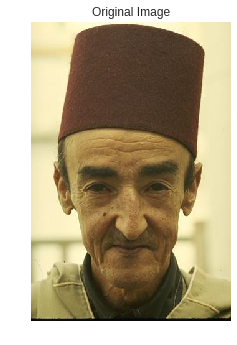

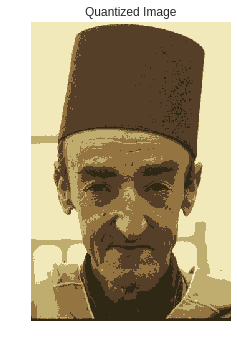

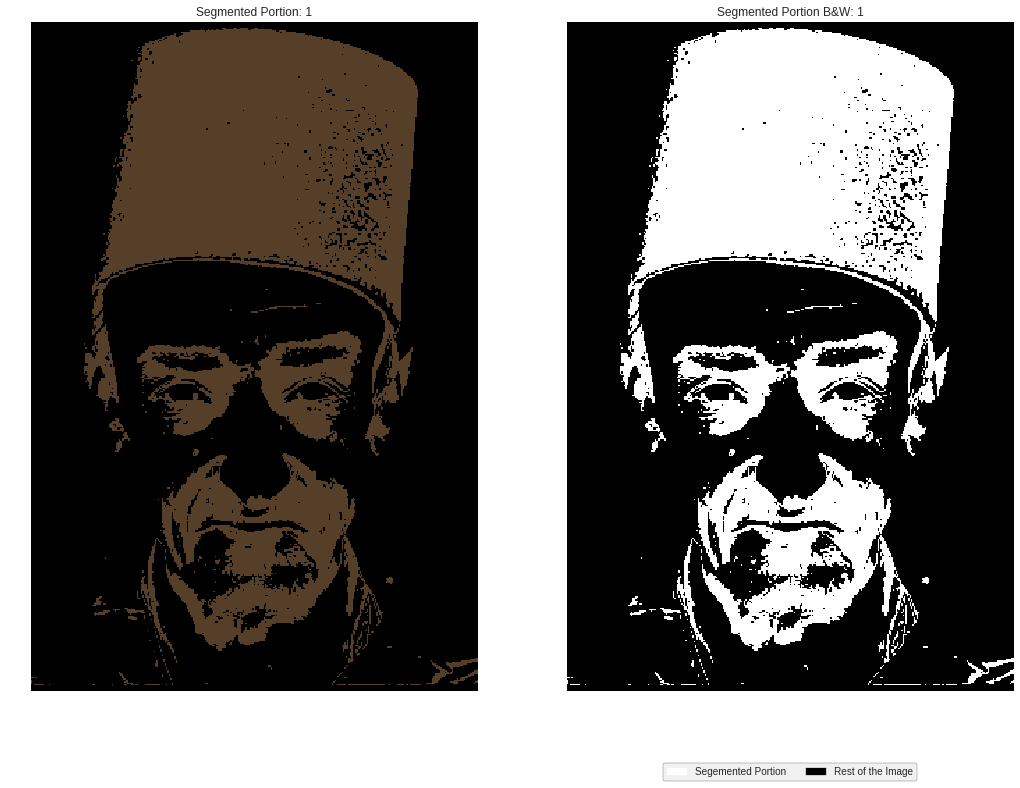

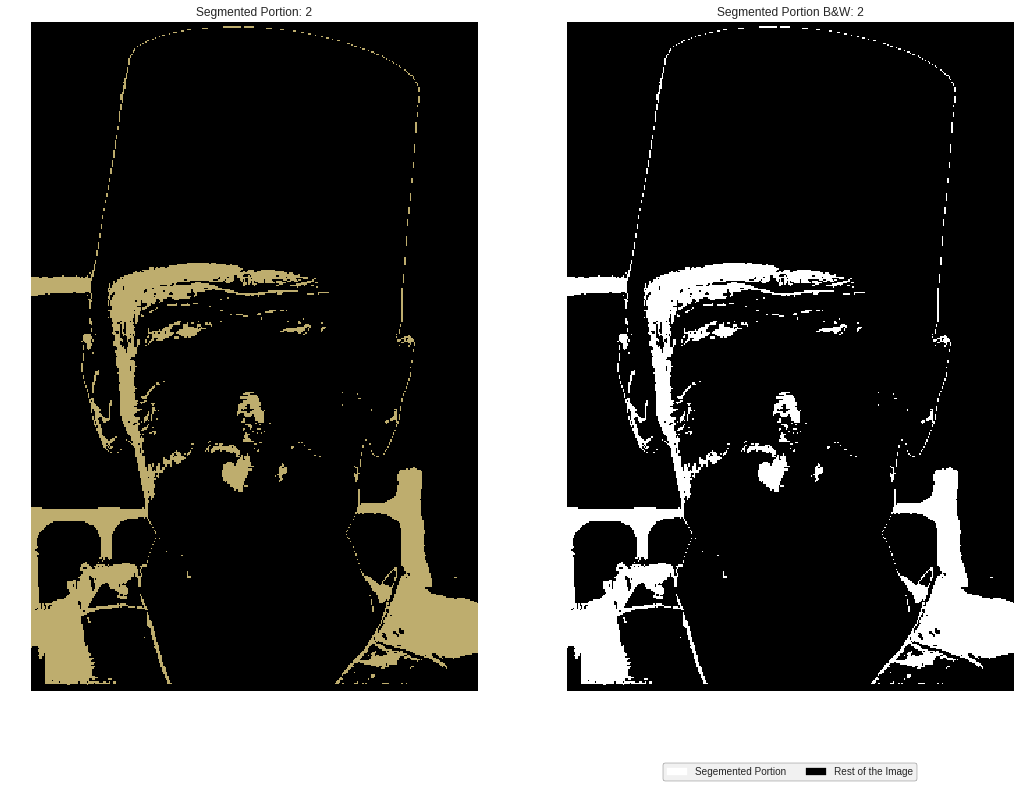

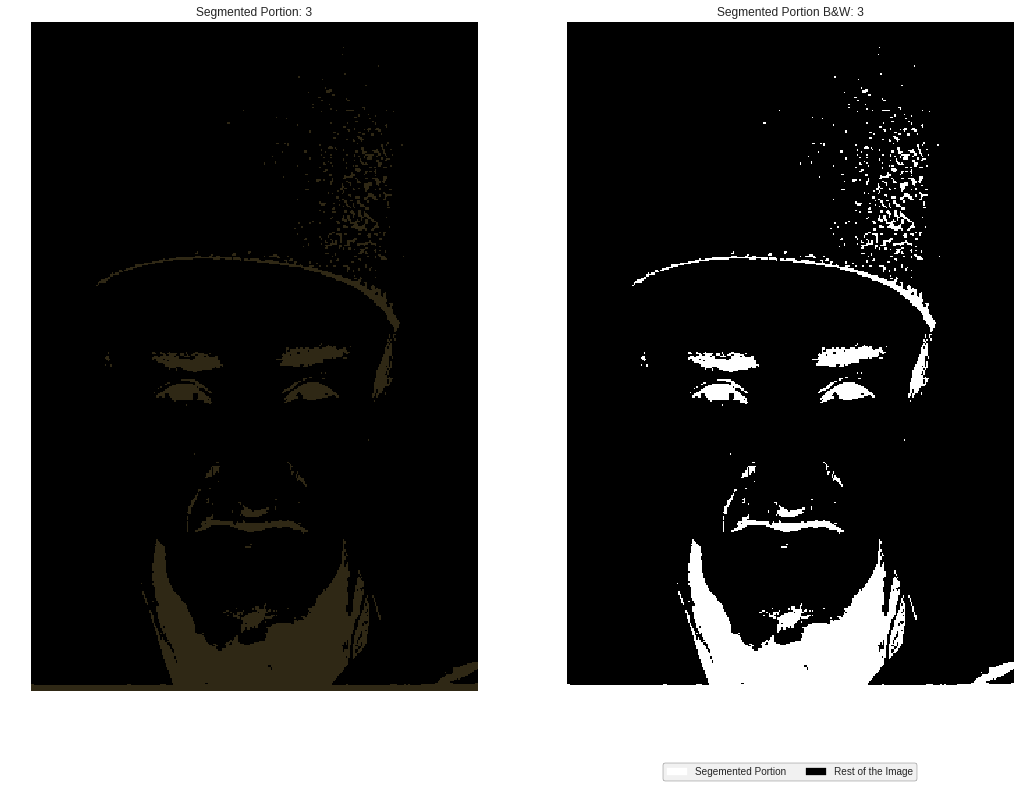

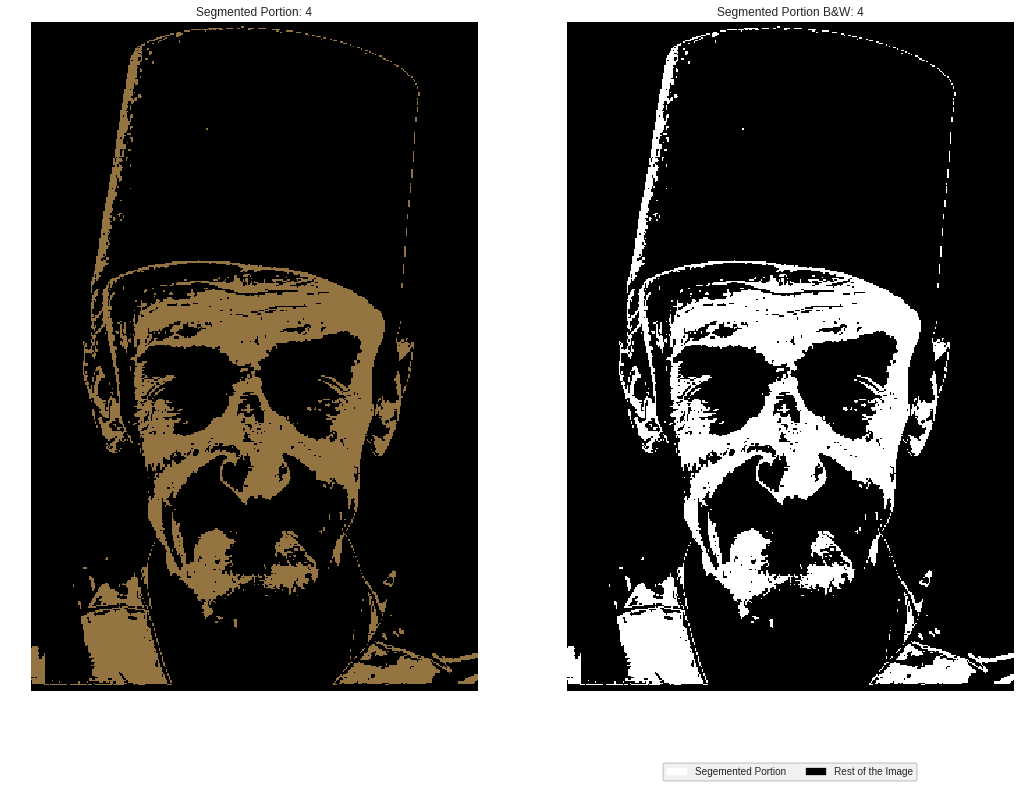

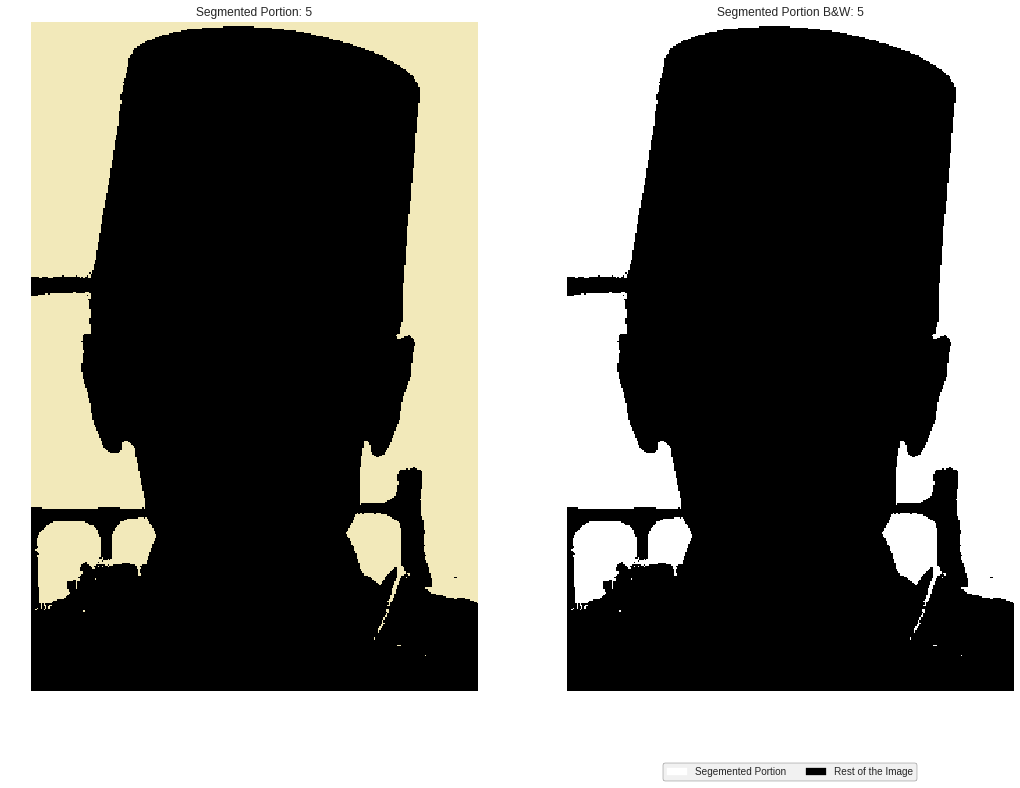

In [14]:
#@title FCM Segmentation { display-mode: "form" }
IMAGE_URL = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/189080.jpg" #@param {type:"string"}
CLUSTER_COUNT = 5 #@param {type:"integer"}
M = 2 #@param {type:"integer"}

url = IMAGE_URL
clusters = CLUSTER_COUNT
m = M
fcm_seg_image,fcm_centers,fcm_labels = fcm_seg(image_url=url,cluster_count=clusters,fuzziness=m)

In [0]:
def compare_images(original_image, kmeans_seg_image, kmeans_centers, fcm_seg_image, fcm_centers):
    print("\n")
    print("K-Means Centers: " + str(np.array(sort_centers(kmeans_centers.tolist()))))
    print("\n")
    print("Fuzzy C-Means Centers: " +
          str(np.array(sort_centers(fcm_centers.tolist()))))
    print("\n")

    # customize plot
    f = plt.figure()
    f.set_figheight(25)
    f.set_figwidth(27)

    f.add_subplot(1, 3, 1)
    plt.axis("off")
    plt.title("K-Means Quantized Image")
    plt.imshow(kmeans_seg_image)

    f.add_subplot(1, 3, 2)
    plt.axis("off")
    plt.title("Original Image")
    plt.imshow(original_image)

    f.add_subplot(1, 3, 3)
    plt.axis("off")
    plt.title("Fuzzy C-Means Quantized Image")
    plt.imshow(fcm_seg_image)




K-Means Centers: [[ 42.08693411  37.71205223  19.16149815]
 [ 86.63870992  63.31210913  40.82181117]
 [146.74429924 116.03797953  64.68244357]
 [189.4780909  171.77250715 109.57383745]
 [241.98963542 232.49428124 185.00826163]]


Fuzzy C-Means Centers: [[ 47.07836201  40.88954117  21.44577052]
 [ 86.70098701  63.25981826  41.57999722]
 [148.23975128 117.42017855  65.17083673]
 [190.25051359 173.43212843 110.9520196 ]
 [242.78179256 233.28926534 186.0491703 ]]




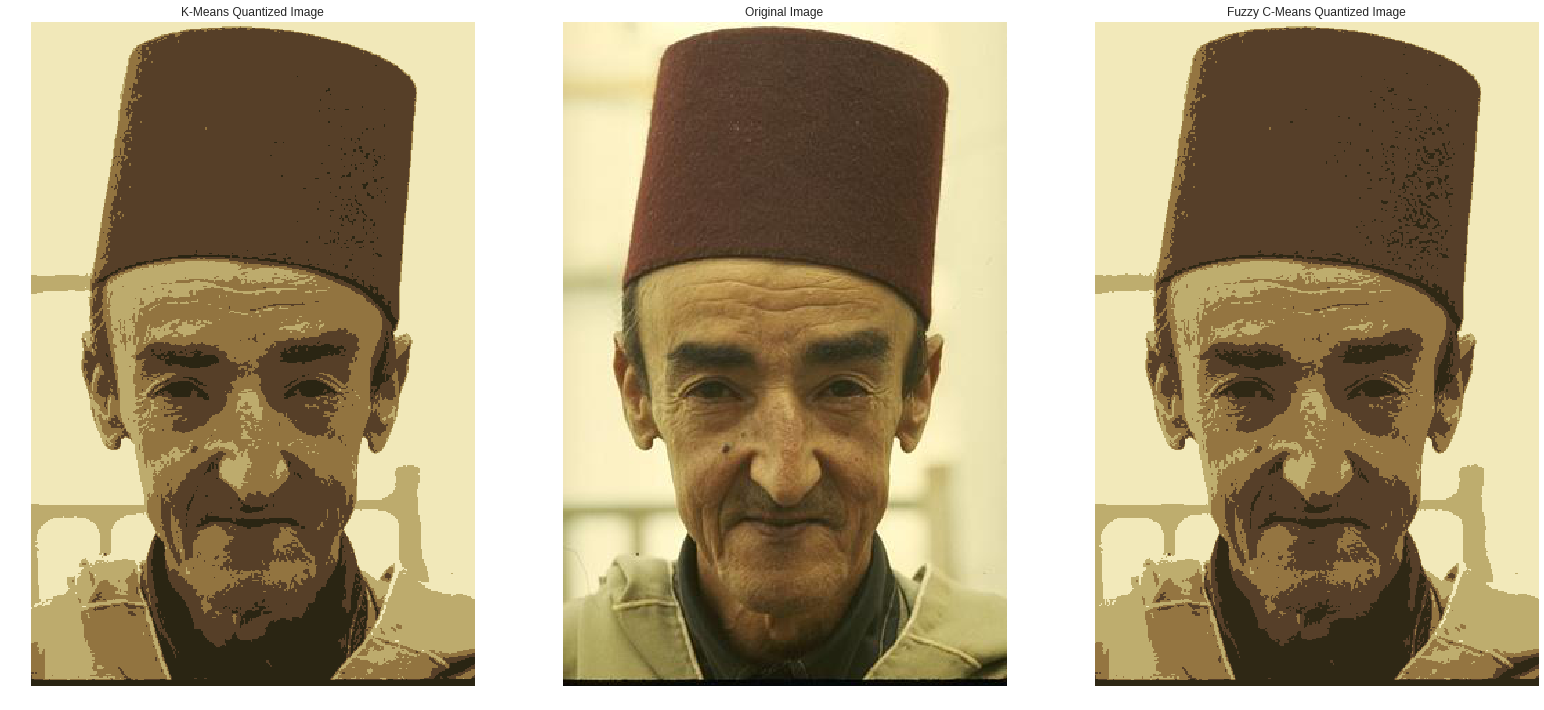

In [16]:
#@title Compare Segmented Images { display-mode: "form" }
IMAGE_URL = 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/189080.jpg'  #@param {type:"string"}

url = IMAGE_URL
original_image = image_to_rgbarray(url_to_image(url))
compare_images(original_image,kmeans_seg_image,kmeans_centers,fcm_seg_image,fcm_centers)

In [17]:
!pip install scikit-image

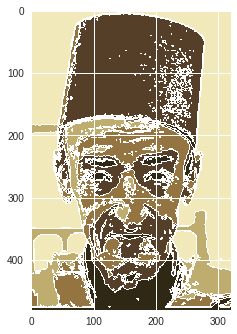

In [18]:
plt.imshow(mark_bounds(fcm_seg_image,fcm_labels,color=(1,1,1),mode ='thick'))